In [9]:
!pip install pandas_ta

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# 지금 터틀전략 시스템에 대해 이해를 하고있는가. 진입, 청산, 피라미딩의 세부 규칙이 추세추종 베팅철학에 부합하는가 이런 것들에 대한 이해를 했는가
import yfinance as yf
import pandas as pd
import requests

start = '2000-01-01'
end = '2024-07-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
data
# data.set_index(data.DatetimeIndex(data["Date"]), inplace=True)
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [32]:
data2 = data.fillna(method='ffill', limit=1)
# data2.to_csv('/Users/dongin/Desktop/my-btester/data2.csv', index=True)

3.43077 sec


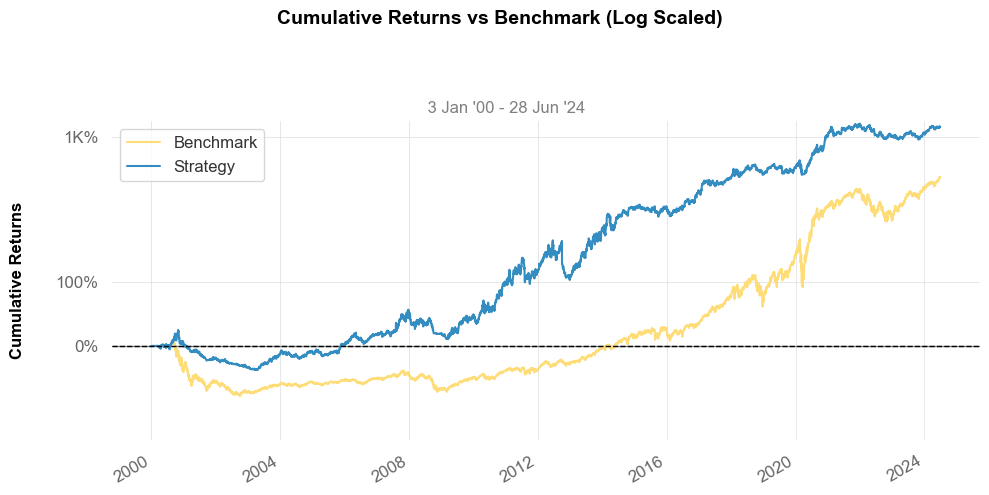

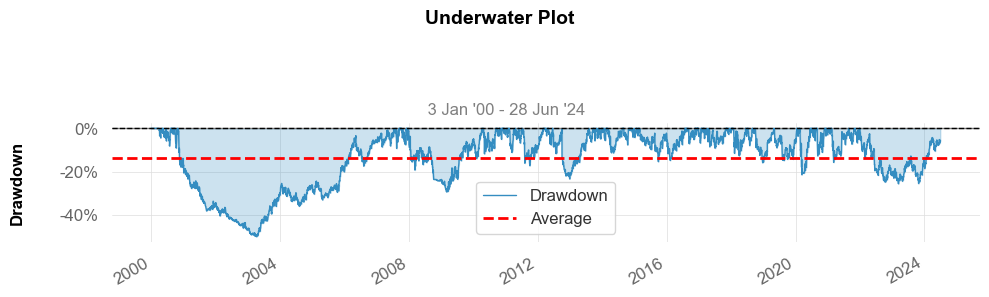

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2000-01-03  2000-01-03
End Period          2024-06-28  2024-06-28
Risk-Free Rate      0.0%        0.0%
Time in Market      99.0%       97.0%

Cumulative Return   1,218.89%   445.43%
CAGR﹪              11.1%       7.17%

Sharpe              0.67        0.4
Sortino             0.95        0.57
Sortino/√2          0.67        0.4
Omega               1.13        1.13

Max Drawdown        -50.01%     -78.99%
Longest DD Days     2467        5031

Gain/Pain Ratio     0.13        0.08
Gain/Pain (1M)      0.69        0.43

Payoff Ratio        0.94        0.87
Profit Factor       1.13        1.08
Common Sense Ratio  1.13        0.99
CPC Index           0.57        0.51
Tail Ratio          1.0         0.92
Outlier Win Ratio   4.7         3.82
Outlier Loss Ratio  4.65        3.38

MTD                 1.33%       7.19%
3M                  -1.48%      7.69%
6M                  10.54%      16.44%

In [27]:
import sys
sys.path.append('/Users/dongin/Desktop/my-btester/myBtester')
from myBtester import Strategy, Backtest
import talib #talib랑 판다스ewm 계산 방식이 다르다. 참고.. 그리고 데이터 중간에 결측값이 하나도 있으면 계산 못함.
import time
import pandas_ta as ta

start = time.time()


class MACrossoverStrategy_RiskManagement_ATR(Strategy):

    def init(self, fast_period: int, slow_period: int):
        self.max_total_unit_risk = .01 # 거래당 1% 리스크 지는 것
        self.highpoint_of_account = 0 #초기 현금으로 최대 계좌 초기화
        self.account_pole = self.cash # 자산 최대값 기준로 리스크단위 증감 계산하기 위함 초기 계좌기준 10%씩 늘어나면 갱신하는 구조로할까

        self.fast_ma = {} #next에서 가격데이터랑 같은 날짜로 반복문이 돌려진다.
        self.slow_ma = {}
        self.atr = {}
        df = pd.DataFrame() # Empty DataFrame

        for symbol in self.symbols:
            self.fast_ma[symbol] = talib.EMA(self.data[(symbol,'Close')], timeperiod=fast_period)
            self.slow_ma[symbol] = talib.EMA(self.data[(symbol,'Close')], timeperiod=slow_period)
            self.atr[symbol] = talib.ATR(self.data[(symbol,'High')], self.data[(symbol,'Low')], self.data[(symbol,'Close')], timeperiod=20)

        
    def next(self, i, record): #지표까지 모두 준비된 데이터에 대해서 모두 동일한 시점에서 시작하는 부분이다. 35,285.57%
      # i는 이동하는 캔들이다. 계속 캔들을 갱신하는 것이다, 지표는 앞전에 init함수로 미리 데이터를 만들어 놓고, 이 부분에서 하나씩 갱신하는 것.
        self.riskSize()

        for symbol in self.symbols:
            # open_condition1 = self.fast_ma[symbol][i-1] > self.slow_ma[symbol][i-1]
            open_condition1 = self.fast_ma[symbol][i-2] < self.slow_ma[symbol][i-2]
            open_condition2 = self.fast_ma[symbol][i-1] > self.slow_ma[symbol][i-1]
            
            # open_condition1 = self.fast_ma[symbol][i-1] < self.slow_ma[symbol][i-1] #왜 현재 0으로 설정하면 그냥 직선으로 돈이 주는지 모르겠음
            # open_condition2 = self.fast_ma[symbol][i-0] > self.slow_ma[symbol][i-0]
            
            if open_condition1 and open_condition2 and self.atr[symbol][i]>0: #해당 종목에서 포지션이 있더라도 조전에 만족하면 그냥 진입함. 피라미딩같은 느낌
                position_size = self.positionSize(record[(symbol,'Open')], self.atr[symbol][i])
                stop_loss = record[(symbol,'Open')]-self.atr[symbol][i]
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=position_size, stopLoss=stop_loss)

        for position in self.open_positions[:]: # [:]리스트 맨 앞부터 맨 뒤까지 불러오는 슬라이싱, i가 돌면서 매 순간마다 포지션을 수시로 불러오는 것다. 그리고 조건이 되면 close를 하는 것이고
            # 매 순간마다 포지션을 모두 불러오고 해당 순간의 가격에 대해서 조건이 맞으면 close를 하는 로직인데.. 처음 진입 시점의 atr을 알아야된다고...
            close_condition1 = self.fast_ma[position.symbol][i-1] < self.slow_ma[position.symbol][i-1]
            stoploss_condition1 = position.stopLoss > record[(position.symbol,'Open')]
            if close_condition1 or stoploss_condition1: #atr만이 청산전략이 아니다. 다른 가격적인 조건이 청산 조건이 추가되어야함. 청산에서 atr은 정해진 리스크량으로 정의하기 위해서 사용된 것
                self.close(position=position, price=record[(position.symbol, 'Open')])


    def positionSize(self, price: float, atr: float):
        if pd.isna(self.cash) or pd.isna(self.assets_value) or pd.isna(self.max_total_unit_risk) or pd.isna(atr):return 0
        return round((self.cash+self.assets_value) * self.max_total_unit_risk / (2*atr)) if price > 0 else 0

    def riskSize(self):
        self.highpoint_of_account = max(self.highpoint_of_account, self.cash+self.assets_value)
        if self.highpoint_of_account > self.account_pole * 1.11: self.account_pole *= 1.11
        # self.account_pole = self.highpoint_of_account
        condition1 = self.cash+self.assets_value < self.account_pole * (1-0.11)
        condition2 = self.cash+self.assets_value < self.account_pole * (1-0.22)
        condition3 = self.cash+self.assets_value < self.account_pole * (1-0.33)
        condition1_2 = self.cash+self.assets_value > self.account_pole * (1-0.22)
        condition2_3 = self.cash+self.assets_value > self.account_pole * (1-0.33)
        condition3_4 = self.cash+self.assets_value > self.account_pole * (1-0.44)
        if condition1 and condition1_2: self.max_total_unit_risk = .01*0.8          *(0.8*0.8*0.8*0.8)
        if condition2 and condition2_3: self.max_total_unit_risk = .01*0.8*0.8      *(0.8*0.8*0.8*0.8)
        if condition3 and condition3_4: self.max_total_unit_risk = .01*0.8*0.8*0.8  *(0.8*0.8*0.8*0.8)
        if not condition1: self.max_total_unit_risk = .01 # 다시 자산이 정상화되면 리스크 단위도 정상화



#초기 자산이 얼마냐에따라 누적 수익이 달라져있음...음 아마 시작 부분이 추세가 없어서 진입할때 가격이 비싸 못사는 경우로 그냥 안사게되니 그럴수도
backtest = Backtest(MACrossoverStrategy_RiskManagement_ATR, data2, commission=.003, cash=1e3)
result = backtest.run(20, 60)
end = time.time()
print(f"{end - start:.5f} sec")


import quantstats as qs
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

qs.reports.metrics(result.returns, benchmark)

qs.reports.html(result.returns, benchmark, output='/Users/dongin/Desktop/my-btester/file-name-nb.html')




In [ ]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

In [29]:
qs.reports.html(result.returns, benchmark, output='/Users/dongin/Desktop/my-btester/file-name-nb.html')